In [1]:
from stim import __version__
print(__version__)

1.15.0


In [2]:
import stim
import numpy as np
import matplotlib.pyplot as plt

# Encoding Circuit

In [3]:
def logical_plus(qc: stim.Circuit, first_qubit: int, p1_err: float, p2_err: float, meas_err: float, encoding_num: int):
    for i in [0, 1, 3]:
        qc.append("H", [first_qubit+i])
        qc.append("DEPOLARIZE1", [first_qubit+i], p1_err)
    
    cx_list = [[first_qubit, first_qubit+4], [first_qubit+1, first_qubit+2], [first_qubit+3, first_qubit+5], [first_qubit, first_qubit+6], [first_qubit+3, first_qubit+4], [first_qubit+1, first_qubit+5], [first_qubit, first_qubit+2], [first_qubit+5, first_qubit+6], [first_qubit+4, first_qubit+7], [first_qubit+2, first_qubit+7], [first_qubit+5, first_qubit+7]]
    for cx in cx_list:
        qc.append("CX", cx)
        qc.append("DEPOLARIZE2", cx, p2_err)
    
    qc.append("X_ERROR", [first_qubit+7], meas_err)
    qc.append("MR", [first_qubit+7])
    qc.append("DETECTOR", [stim.target_rec(encoding_num)])
    
    for i in range(7):
        qc.append("H", [first_qubit+i])
        qc.append("DEPOLARIZE1", [first_qubit+i], p1_err)

# Measurement Circuit

In [4]:
def final_measurements(qc: stim.Circuit, meas_err: float):
    qc.append("X_ERROR", range(7), meas_err)
    qc.append("MR", range(7))

    # Stabilizers
    qc.append("OBSERVABLE_INCLUDE", [stim.target_rec(-7), stim.target_rec(-5), stim.target_rec(-3), stim.target_rec(-1)], 0)
    qc.append("OBSERVABLE_INCLUDE", [stim.target_rec(-4), stim.target_rec(-3), stim.target_rec(-2), stim.target_rec(-1)], 1)
    qc.append("OBSERVABLE_INCLUDE", [stim.target_rec(-6), stim.target_rec(-5), stim.target_rec(-2), stim.target_rec(-1)], 2)
    
    # Logical Operator 
    qc.append("OBSERVABLE_INCLUDE", [stim.target_rec(-7), stim.target_rec(-6), stim.target_rec(-5)], 3)

# Entire Hadamard Circuit

In [5]:
def hadamard_circuit(qc: stim.Circuit, p1_err: float, p2_err: float, meas_err: float, rep: int):
    logical_plus(qc, first_qubit=0, p1_err=p1_err, p2_err=p2_err, meas_err=p2_err, encoding_num=-1)
    
    for r in range(rep):
        for i in range(7):
            qc.append("H", [i])
            qc.append("DEPOLARIZE1", [i], p1_err)
    final_measurements(qc, meas_err)

# Decoder

In [6]:
def decoder(dets, obs):
    shots = obs.shape[0]
    error = 0
    erase = 0
    
    for i in range(shots):
        if (not dets[i][0]):
            checks = obs[i][0:3]
            op = obs[i][3]
            if (checks[1]):
                pass
            elif (checks[0] or checks[2]):
                op = not op 
            
            if (op):
                error += 1
        else:
            erase += 1
            
    err_rate = error/(shots - erase)
    unc = 1.96 * np.sqrt( (err_rate * (1 - err_rate) / (shots - erase) ))
    return err_rate, unc

# Simulations

Text(0, 0.5, 'logical error')

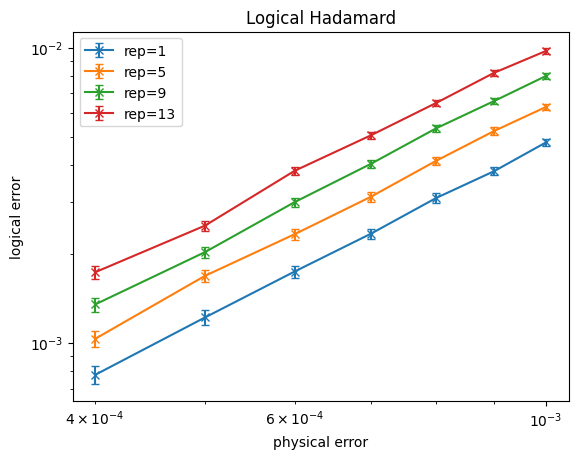

In [15]:
noise_list = [0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001]
shots = int(1e6)
all_error = []
all_unc = []

for rep in range(1, 14, 4):
    logical_err = []
    unc = []
    for p1 in noise_list:
        qc = stim.Circuit()
        hadamard_circuit(qc, p1_err=p1, p2_err=p1*10, meas_err=p1*10, rep=rep)

        dets, obs = qc.compile_detector_sampler().sample(shots=shots,separate_observables=True)
        err_rate, u = decoder(dets, obs)
        logical_err.append(err_rate)
        unc.append(u)
    plt.errorbar(
        noise_list,
        logical_err,
        yerr=unc,
        fmt='-x',
        label=f'rep={rep}',
        capsize=3  # little horizontal caps on the error bars
    )
    all_error.append(logical_err)
    all_unc.append(unc)
    
plt.title('Logical Hadamard')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('physical error')
plt.ylabel('logical error')

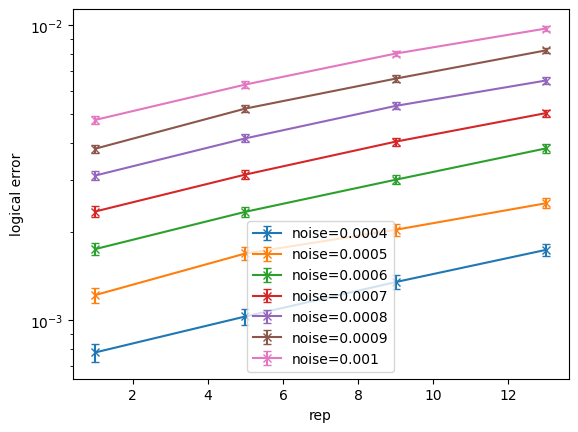

In [16]:
# all_error.shape == (num_reps, num_noises)
# uncertainties.shape == (num_reps, num_noises)
all_error = np.array(all_error)
all_unc = np.array(all_unc)
num_reps, num_noises = all_error.shape

x = range(1, 14, 4)

for k in range(num_noises):
    plt.errorbar(
        x,
        all_error[:, k],
        yerr=all_unc[:, k],
        fmt='-x',
        capsize=3,
        label=f'noise={noise_list[k]}'
    )

plt.yscale('log')
plt.legend()
plt.xlabel('rep')
plt.ylabel('logical error')
plt.show()

In [17]:
x = np.array(list(range(1, 14, 4)))
slopes = []

for k, noise in enumerate(noise_list):
    y = all_error[:, k]               # error vs rep for this noise
    # fit a straight line to (x, log10(y))
    m, b = np.polyfit(x, np.log10(y), 1)
    slopes.append(m)
    print(f"noise={noise:0.4f} → slope = {m:.4f} decades per rep")

noise=0.0004 → slope = 0.0290 decades per rep
noise=0.0005 → slope = 0.0253 decades per rep
noise=0.0006 → slope = 0.0283 decades per rep
noise=0.0007 → slope = 0.0278 decades per rep
noise=0.0008 → slope = 0.0269 decades per rep
noise=0.0009 → slope = 0.0275 decades per rep
noise=0.0010 → slope = 0.0259 decades per rep


In [18]:
rounded = [np.round(i, 4) for i in slopes]
print(rounded)
rounded.sort()
print(rounded)

[np.float64(0.029), np.float64(0.0253), np.float64(0.0283), np.float64(0.0278), np.float64(0.0269), np.float64(0.0275), np.float64(0.0259)]
[np.float64(0.0253), np.float64(0.0259), np.float64(0.0269), np.float64(0.0275), np.float64(0.0278), np.float64(0.0283), np.float64(0.029)]
